In [ ]:
# DeCET application to REMC muscle types

In [1]:
import numpy as np
import torch
import scipy
import matplotlib.pyplot as plt
import sklearn.decomposition
from sklearn import svm
from collections import defaultdict
from collections import Counter
from matplotlib import rcParams
import matplotlib.patches as mpatches
import seaborn
import os

seaborn.set(font='Arial')
plt.style.use('default')
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = 11
rcParams['pdf.fonttype'] = 42
plt.rcParams.update({"text.color": 'k'})

import sys
sys.path.append('./')
import auxiliary_bed_functions as abf

date = '5_11_20' # Change this to today's date for output names.

input_dir = '../DeCET_REMC/' # directory where the HOSVD files can be found
file_prefix = 'DeCET_REMC_muscle_types_final' # prefix used for input files
output_dir = '../' # directory to write output

In [2]:
# Read in the projections from the tensor decomposition.
fp = open( input_dir + file_prefix + '_projections.txt', 'r')

index = []
projections = []
for line in fp:
    l = line.strip().split(':')
    index.append([int(l[0].split(',')[0]), int(l[0].split(',')[1])])
    projections.append(l[1].strip().split(','))

print(len(index), len(projections[0]))
n_pt = 10
n_as = 5
fp.close()

sample_proj = np.zeros((n_pt, n_as, len(projections[0])))

for k in range(0,len(projections)):
    sample_proj[index[k][0], index[k][1]] = projections[k]

50 50


In [3]:
# Full and reduced labels for the REMC data files used in this study.
# Colors for the different muscle types and assays.

muscle_type_colors = [(1.0,0.0,0.0,1.0), (1.0,0.0,0.0,1.0), (1.0,0.0,0.0,1.0),
                      (0.0,1.0,0.0,1.0), (0.0,1.0,0.0,1.0), (0.0,1.0,0.0,1.0),
                      (0.0,1.0,0.0,1.0), (0.0,1.0,0.0,1.0),
                      (0.0,0.0,1.0,1.0), (0.0,0.0,1.0,1.0)]

sample_labels = ['E104 Right atrium', 'E105 Right ventricle', 'E095 Left ventricle',
                 'E065 Aorta', 'E076 Colon smooth muscle', 'E078 Duodenum smooth muscle',
                 'E103 Rectal smooth muscle', 'E111 Stomach smooth muscle',
                 'E100 Psoas muscle', 'E108 Skeletal muscle female']

sample_labels_short = ['E104', 'E105', 'E095', 'E065',
                       'E076', 'E078', 'E103', 'E111',
                       'E100', 'E108']

assay_colors = [(51/255,70/255,0,1.0), (204/255,20/255,204/255,1.0), 
                (104/255,20/255,104/255,1.0), (204/255,102/255,0,1.0), (162/255,148/255,80/255,1.0)]

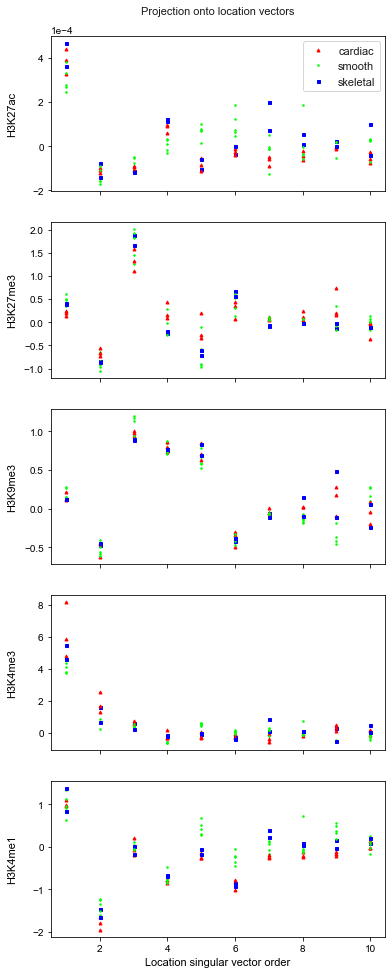

In [4]:
# Stacked projections
fig = plt.figure(figsize=(6,20))

n_proj = 10
assay_name = ['H3K27ac', 'H3K27me3',
              'H3K9me3', 'H3K4me3', 'H3K4me1']

ax = []
for k in range(n_as):
    assay = k
    ax.append(fig.add_subplot(611+k)) 
    l1, = ax[k].plot(sample_proj[0, assay][0:n_proj],'^', markersize=3, c=(1,0,0,1))
    l2, = ax[k].plot(sample_proj[3, assay][0:n_proj],'.', markersize=3, c=(0,1,0,1))
    l3, = ax[k].plot(sample_proj[8, assay][0:n_proj],'s', markersize=3, c=(0,0,1,1))
    for i in range(1,3):
        ax[k].plot(sample_proj[i, assay][0:n_proj],'^', markersize=3, c=(1,0,0,1))
    for i in range(0,4):
        ax[k].plot(sample_proj[i+4, assay][0:n_proj],'.', markersize=3, c=(0,1,0,1))
    for i in range(1,2):
        ax[k].plot(sample_proj[i+8, assay][0:n_proj],'s', markersize=3, c=(0,0,1,1))

    if(k == 0):
        plt.title('Projection onto location vectors',fontsize=11,y=1.1)
        ax[k].legend([l1, l2, l3], ["cardiac", "smooth", "skeletal"], fontsize=11)
        
    ax[k].set_ylabel(assay_name[k],fontsize=11)
    ax[k].get_yaxis().set_label_coords(-0.1,0.5)
    ax[k].ticklabel_format(axis='y', style='sci', scilimits=(0.0,0.0))
    if(k < n_as-1): 
        plt.setp(ax[k].get_xticklabels(), visible=False)
    if(k != 0):
        ax[k].yaxis.get_offset_text().set_visible(False)
    
    
    if(k == n_as-1):
        ax[k].set_xlabel('Location singular vector order',fontsize=11)
        plt.setp(ax[k].get_xticklabels(), visible=True)
        plt.xticks([2*i+1 for i in range(int(n_proj/2))], [2*(i+1) for i in range(int(n_proj/2))])
    plt.setp(ax[k].get_xticklabels(), visible=True)
    plt.xticks([2*i+1 for i in range(int(n_proj/2))], [2*(i+1) for i in range(int(n_proj/2))])

In [5]:
def matrix_cosine(X, Y):
    """Calculates the matrix cosine distance.
    
    The cosine distance is computed for matching
    rows of the X and Y matrices and these values
    are summed over the rows.
    """
    K, N = X.shape
    dist = 0.0
    for k in range(K):
        dist += scipy.spatial.distance.cosine(X[k,:], Y[k,:])
    return dist

# Calculate the adjusted matrix cosine distance between 
# each pair of tissue samples.
# Select the number of location vectors to use for clustering.
use = [i for i in range(10)]
tissue_sample = np.copy(sample_proj[:,:,np.sort(use)])
print(tissue_sample.shape)

# Mean center the data across tissue samples for each assay.
for k in range(n_as):
    tissue_sample[:,k,:] = tissue_sample[:,k,:] - np.mean(tissue_sample[:,k,:], axis=0)
    
D = np.zeros((n_pt, n_pt))
for i in range(n_pt):
    for j in range(n_pt):
        D[i,j] = matrix_cosine(tissue_sample[i], tissue_sample[j])

(10, 5, 10)


In [6]:
# Reorder the assays to group marks associated with active and repressive
# gene transcription. This makes it easier to see trends in the projections.
reorder_assays = [0,3,4,1,2]

index_order = []
col_loc_color = []
single_col_color = []
col_assay = []
for l in range(len(use)):
    if(l % 2 == 0):
        single_col_color.append('k')
    else:
        single_col_color.append((0.5,0.5,0.5,1))
    for k in range(n_as):
        index_order.append(len(use)*k + l)
        col_assay.append(assay_colors[reorder_assays[k]])
    if(l % 2 == 0):
        for k in range(n_as):
            col_loc_color.append('k')
    else:
        for k in range(n_as):
            col_loc_color.append((0.5,0.5,0.5,1))

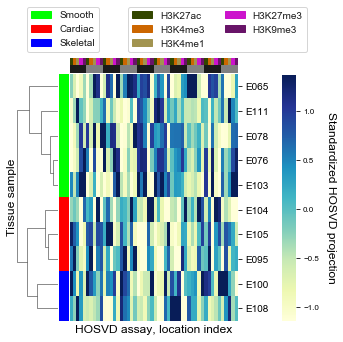

In [7]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

# Figure 2B (unsupervised hierarchical clustering of muscle tissues)
legend_TN= [mpatches.Patch(color=c, label=l) for c,l in zip([(0.0,1.0,0.0,1.0), (1.0,0.0,0.0,1.0), (0.0,0.0,1.0,1.0)], ["Smooth", "Cardiac", "Skeletal"])]
legend_assay = [mpatches.Patch(color=c, label=l) for c,l in zip([assay_colors[i] for i in reorder_assays], [assay_name[i] for i in reorder_assays])]

full_sample_proj = np.concatenate((sample_proj[:,reorder_assays[0],np.sort(use)],
                                   sample_proj[:,reorder_assays[1],np.sort(use)],
                                   sample_proj[:,reorder_assays[2],np.sort(use)],
                                   sample_proj[:,reorder_assays[3],np.sort(use)],
                                   sample_proj[:,reorder_assays[4],np.sort(use)]), axis=1)

# For each assay-location vector mean center and
# and scale to unit variance across samples.
full_scaled_proj = np.divide(full_sample_proj - np.mean(full_sample_proj, axis=0), np.std(full_sample_proj,axis=0))

# Obtain a hierarchical clustering using the adjusted
# matrix cosine distance and an average linkage.
linkage = hc.linkage(sp.distance.squareform(D), method='average')

# Make the cluster map. 
g = seaborn.clustermap(full_scaled_proj[:,index_order], row_linkage=linkage, cmap="YlGnBu",
                       row_cluster=True, col_cluster=False, robust=False, row_colors=muscle_type_colors,
                       col_colors=[col_assay, col_loc_color],
                       xticklabels = [], yticklabels=sample_labels_short, figsize=(4,6),
                       vmin = np.percentile(full_scaled_proj.flatten(), 10, interpolation='nearest'),
                       vmax = np.percentile(full_scaled_proj.flatten(), 90, interpolation='nearest'))

g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), fontsize=10, rotation=0)
g.ax_col_dendrogram.set_visible(False)
g.cax.set_position([1.05,0.125,0.05,0.57])
plt.setp(g.cax.get_yticklabels(), fontsize=8)
g.cax.set_ylabel('Standardized HOSVD projection', rotation=270, fontsize=12, labelpad=17)
        
l2=g.ax_heatmap.legend(loc='lower left', bbox_to_anchor=(-0.28,1.07), handles=legend_TN,
                       frameon=True, fontsize=10)
g.cax.legend(loc='lower left', bbox_to_anchor=(-11.0,1.07), handles=legend_assay,
                       frameon=True, fontsize=10, ncol=2)

g.ax_heatmap.set_xlabel('HOSVD assay, location index', fontsize=12)
g.ax_heatmap.set_ylabel('Tissue sample', fontsize=12)
g.ax_heatmap.yaxis.set_label_coords(-0.37,0.5)

g.savefig(output_dir + 'figures/figure2_panels/' + file_prefix + '_panelB_clustering_' +
          date + '.pdf', format='pdf', transparent=True)

In [8]:
np.sort(use) + 1

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

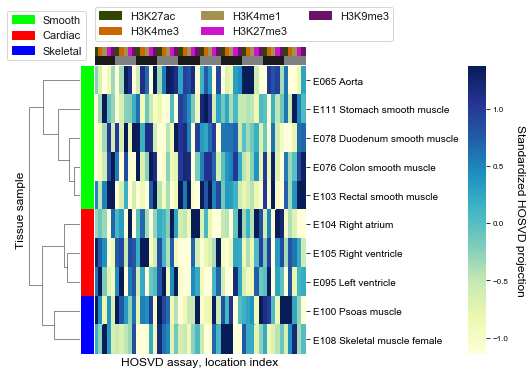

In [9]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

# Figure 2B (unsupervised hierarchical clustering of tissue samples) full labels
legend_TN = [mpatches.Patch(color=c, label=l) for c,l in zip([(0.0,1.0,0.0,1.0), (1.0,0.0,0.0,1.0), (0.0,0.0,1.0,1.0)], ["Smooth", "Cardiac", "Skeletal"])]
legend_assay = [mpatches.Patch(color=c, label=l) for c,l in zip([assay_colors[i] for i in reorder_assays], [assay_name[i] for i in reorder_assays])]

full_sample_proj = np.concatenate((sample_proj[:,reorder_assays[0],np.sort(use)],
                                   sample_proj[:,reorder_assays[1],np.sort(use)],
                                   sample_proj[:,reorder_assays[2],np.sort(use)],
                                   sample_proj[:,reorder_assays[3],np.sort(use)],
                                   sample_proj[:,reorder_assays[4],np.sort(use)]), axis=1)

# For each assay-location vector mean center and
# and scale to unit variance across samples.
full_scaled_proj = np.divide(full_sample_proj - np.mean(full_sample_proj, axis=0),
                             np.std(full_sample_proj,axis=0))

# Obtain a hierarchical clustering using the adjusted
# matrix cosine distance and an average linkage.
linkage = hc.linkage(sp.distance.squareform(D), method='average')

# Make the cluster map. 
g = seaborn.clustermap(full_scaled_proj[:,index_order], row_linkage=linkage, cmap="YlGnBu",
                       row_cluster=True, col_cluster=False, robust=False, row_colors=muscle_type_colors,
                       col_colors=[col_assay, col_loc_color],
                       xticklabels = [], yticklabels=sample_labels, figsize=(5,7),
                       vmin = np.percentile(full_scaled_proj.flatten(), 10, interpolation='nearest'),
                       vmax = np.percentile(full_scaled_proj.flatten(), 90, interpolation='nearest'))

g.ax_col_dendrogram.set_visible(False)
g.cax.set_position([1.35,0.125,0.05,0.57])
plt.setp(g.cax.get_yticklabels(), fontsize=8)
g.cax.set_ylabel('Standardized HOSVD projection', rotation=270, fontsize=12, labelpad=17)
        
l2=g.ax_heatmap.legend(loc='lower left', bbox_to_anchor=(-0.44,1.0), handles=legend_TN,
                       frameon=True, fontsize=11)
g.cax.legend(loc='lower left', bbox_to_anchor=(-21.0,1.07), handles=legend_assay,
                       frameon=True, fontsize=11, ncol=3)

g.ax_heatmap.set_xlabel('HOSVD assay, location index', fontsize=12)
g.ax_heatmap.set_ylabel('Tissue sample', fontsize=12)
g.ax_heatmap.yaxis.set_label_coords(-0.37,0.5)

In [10]:
# Load in the decomposition of the genomic location space.
U_l = torch.load(input_dir + file_prefix + '_factor_matrix_2.pt', map_location='cpu').numpy()

L_genome = U_l.shape[0]
print(U_l.shape)

(1440549, 50)


In [11]:
# The genomic bins used for the hg19 genome. chrY is 
# removed from the data before the HOSVD. Since chrY is
# at the end of the chromosome list used, this is
# not a problem.
chr_list = abf.getChrList()
chr_length = {'chrY': 59373566, 'chrX': 155270560, 'chr13': 115169878,
              'chr12': 133851895, 'chr11': 135006516, 'chr10': 135534747,
              'chr17': 81195210, 'chr16': 90354753, 'chr15': 102531392,
              'chr14': 107349540, 'chr19': 59128983, 'chr18': 78077248,
              'chrM': 16571, 'chr22': 51304566, 'chr20': 63025520,
              'chr21': 48129895, 'chr7': 159138663, 'chr6': 171115067,
              'chr5': 180915260, 'chr4': 191154276, 'chr3': 198022430,
              'chr2': 243199373, 'chr1': 249250621, 'chr9': 141213431,
              'chr8': 146364022}
bin_size = 2000

genomic_bin = [[] for l in range(0,1547874)]
counter = 0
for chrom in chr_list:
    for l in range(0, int(np.ceil(chr_length[chrom]/bin_size))+1):
        genomic_bin[counter] = [chrom, l*bin_size, (l+1)*bin_size]
        counter += 1
print(genomic_bin[72537])
print(counter)

['chr1', 145074000, 145076000]
1547874


In [12]:
# Get the bins (location vector components representing genomic regions)
# that are significantly non-zero for the location vector that separates
# the conditions.

# Select the location vector of interest (zero indexed).
loc_vec = 6

# Set the threshold for a vector component to be considered significant.
# The empirical distribution of component values from all vectors is used
# to set the threshold.

cut = np.percentile(np.absolute(U_l), 99.9, interpolation='nearest')

significant_pos = []
significant_neg = []
for i in range(L_genome):
    if(U_l[i,loc_vec] > cut):
        significant_pos.append(i)
    elif(U_l[i,loc_vec] < -cut):
        significant_neg.append(i)
        
print(len(significant_pos), 'positive')
print(len(significant_neg), 'negative')

# Save the regions exhibiting epigenetic alterations 
# between leiomyoma and myometrium. 1-based indexing
# is used for the file names.

output_pos = open(output_dir + 'region_files/' + file_prefix + '_pos_loc' + str(loc_vec+1) + '.txt','w+')

for l in range(0,len(significant_pos)):
            output_pos.write('{}\t{}\t{}\n'.format(genomic_bin[significant_pos[l]][0], genomic_bin[significant_pos[l]][1], genomic_bin[significant_pos[l]][2]))     
output_pos.close()

output_neg = open(output_dir + 'region_files/' + file_prefix + '_neg_loc' + str(loc_vec+1) + '.txt','w+')

for l in range(0,len(significant_neg)):
            output_neg.write('{}\t{}\t{}\n'.format(genomic_bin[significant_neg[l]][0], genomic_bin[significant_neg[l]][1], genomic_bin[significant_neg[l]][2]))
output_neg.close()

1987 positive
1474 negative
